# Setup

In [79]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from statsmodels.stats.multitest import multipletests



In [2]:
df = pd.read_json("../data/craft-ml-data.jsonl", lines=True)
df.columns

Index(['text', 'labels'], dtype='object')

# Label Counts

In [3]:
df["labels"].value_counts()

labels
[]                                                                    137
[natural_disasters]                                                    41
[labor_workforce_compliance_human_rights]                              30
[financial_distress]                                                   29
[geopolitical_issues]                                                  27
[financial_success]                                                    26
[investments]                                                          26
[supplychain]                                                          25
[epidemics_and_pandemics]                                              24
[financial_success, investments]                                        6
[epidemics_and_pandemics, supplychain]                                  6
[geopolitical_issues, supplychain]                                      4
[financial_distress, supplychain]                                       4
[geopolitical_issues, investmen

### Takeaway

Need to accoutn for multiclass

In [52]:
all_labels = df.explode('labels')
label_counts = all_labels['labels'].value_counts()
print(label_counts)

labels
natural_disasters                          41
supplychain                                41
investments                                40
financial_distress                         39
geopolitical_issues                        36
epidemics_and_pandemics                    34
financial_success                          34
labor_workforce_compliance_human_rights    31
Name: count, dtype: int64


### Takeaway

Dataset is relatively balanced

# Data Split

### Perform train test split before EDA to prevent peeking

In [5]:
labeled_df = df[df['labels'].str.len() > 0]
unlabeled_df = df[df['labels'].str.len() == 0]

print(f"Labeled: {len(labeled_df)}, Unlabeled: {len(unlabeled_df)}")

train_df, test_df = train_test_split(
    labeled_df, test_size=0.2, random_state=42
)

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

test_df.to_json("../data/craft-ml-data-test.jsonl", lines=True, orient="records")

test_df.to_json(
    "../data/craft-ml-data-train.jsonl", lines=True, orient="records"
)

unlabeled_df.to_json(
    "../data/craft-ml-data-predict.jsonl", lines=True, orient="records"
)


Labeled: 261, Unlabeled: 137
Train size: 208, Test size: 53


# Text Length By Label

In [6]:
train_df = pd.read_json("../data/craft-ml-data-train.jsonl", lines=True)

train_df['char_count'] = train_df['text'].str.len()
train_df['word_count'] = train_df['text'].str.split().str.len()

train_df_exp = train_df.explode('labels')

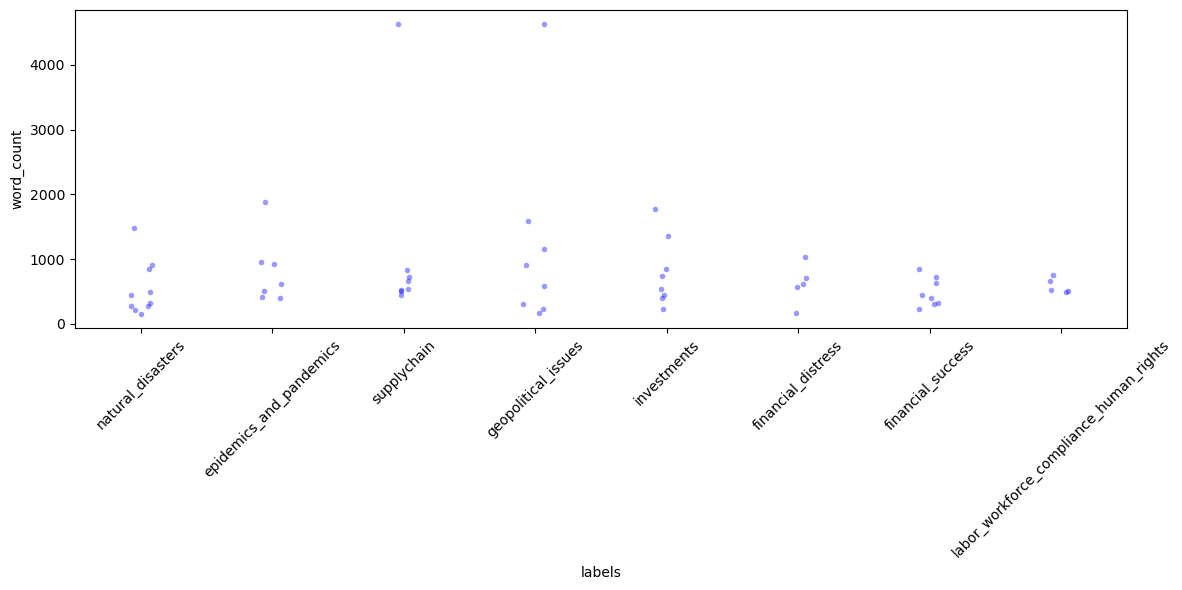

In [25]:
plt.figure(figsize=(12, 6))

sns.stripplot(
    x='labels', y='word_count', data=train_df_exp,
    jitter=True, alpha=0.4, color='blue', size=4
)
plt.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Takeaway

Means appear about the same, Variances may differe but low sample count. Run a test to confirm

In [13]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('word_count ~ C(labels)', data=train_df_exp).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                 sum_sq    df         F    PR(>F)
C(labels)  3.816162e+06   7.0  0.787836  0.600696
Residual   3.529091e+07  51.0       NaN       NaN


### Takeaway

No signifficant differences

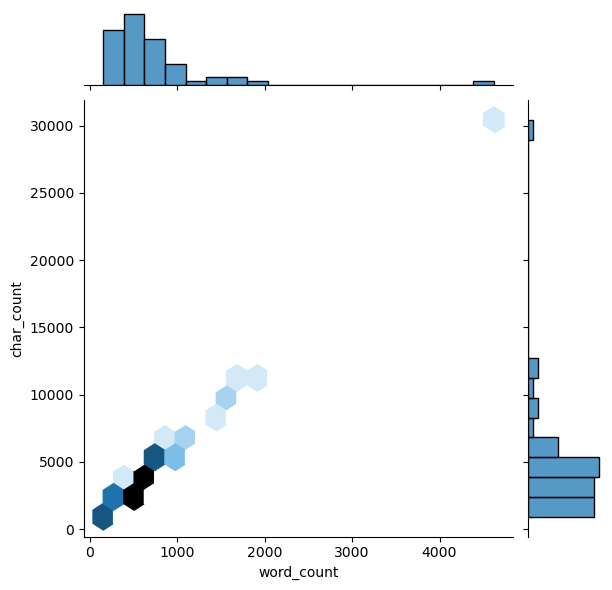

,char_count,word_count
char_count,1.00000,0.99899
word_count,0.99899,1.00000


In [15]:
sns.jointplot(data=train_df, x="word_count", y="char_count", kind="hex")
plt.show()

train_df_exp[["char_count", "word_count"]].corr()

### Takeaway

Word count and char count represent the same signal

# Keyword Exploration

## TFIDF

In [111]:
vect = TfidfVectorizer(
    max_df = .75 # Remove words in more than 75% of the documents
    ,min_df = 5 # Only keep words in at least 5 documents
    ,ngram_range= (1,2) # unigrams and bigrams
    ,stop_words = "english"
)

X_tfidf = vect.fit_transform(train_df_exp['text'])
feature_names = np.array(vect.get_feature_names_out())


In [112]:
tfidf_sums = np.array(X_tfidf.sum(axis=0)).ravel()
top20 = feature_names[np.argsort(tfidf_sums)[-20:]][::-1]

print("Top 20 words by TFIDF score:")
for term in top20:
    print(" •", term)

Top 20 words by TFIDF score:
 • said
 • company
 • supply
 • year
 • billion
 • china
 • supply chain
 • million
 • chain
 • data
 • states
 • court
 • market
 • new
 • sales
 • companies
 • air
 • business
 • bankruptcy
 • according


In [113]:
print(labels)

['natural_disasters' 'epidemics_and_pandemics' 'supplychain'
 'geopolitical_issues' 'investments' 'financial_distress'
 'financial_success' 'labor_workforce_compliance_human_rights']


In [114]:
n = 15 # Number of top terms to show per label
labels = train_df_exp['labels'].unique()
rows = []

for lbl in labels:
    msk = train_df_exp['labels'] == lbl
    
    top_scores = X_tfidf[msk.values].sum(axis=0).A1
    top_terms = feature_names[np.argsort(top_scores)[-n:]][::-1]

    max_scores = X_tfidf[msk.values].max(axis=0).toarray().ravel()
    top_terms_max = feature_names[np.argsort(max_scores)[-n:]][::-1]

    rows.append({"label": lbl, "top_terms_sum": top_terms.tolist(), "top_terms_max": top_terms_max.tolist()})


# Dataframe for Display
df_top_terms = pd.DataFrame(rows)
pd.set_option('display.max_colwidth', None)
display(df_top_terms)

,label,top_terms_sum,top_terms_max
0,natural_disasters,"[air, weather, tuesday, said, delivery, delays, says, flooding, damage, amazon, days, 000, aug, food, record]","[air, tuesday, aug, says, delivery, 000, support, record, food, beijing, emergency, china, near, weather, storm]"
1,epidemics_and_pandemics,"[said, percent, pandemic, supply, supply chain, chain, freight, covid 19, air, risk, covid, sales, company, 19, countries]","[freight, air, percent, won, sales, said, risk, tuesday, oil, supply chain, countries, brands, supply, response, china]"
2,supplychain,"[supply, supply chain, chain, design, states, united states, united, shortages, raw, materials, innovation, oil, product, said, freight]","[design, shortages, innovation, plant, major, climate, oil, supply chain, supply, united states, health, states, canada, chain, product]"
3,geopolitical_issues,"[china, data, security, supply, said, taiwan, supply chain, researchers, chain, north, cross, year, united states, states, united]","[china, taiwan, data, supply, researchers, north, bank, innovation, cross, supply chain, year, security, adjusted, chain, united states]"
4,investments,"[company, billion, acquisition, securities, sales, debt, capital, year, said, term, offering, million, ripple, investors, market]","[ripple, sales, securities, acquisition, debt, cloud, prices, climate, term, billion, digital, company, oil, 2022, court]"
5,financial_distress,"[bankruptcy, court, group, plan, said, retail, company, business, filed, operations, consumers, home, investors, rights, filing]","[bankruptcy, group, retail, court, home, consumers, rights, transaction, offer, said, spending, administration, earnings, resources, debt]"
6,financial_success,"[billion, company, year, growth, shares, cloud, capital, said, million, price, stock, market, net, traffic, prices]","[traffic, debt, cloud, shares, prices, billion, cybersecurity, 400, year, oil, 2022, acquired, strong, carbon, software]"
7,labor_workforce_compliance_human_rights,"[law, workers, ai, court, labor, work, tech, working, company, china, legal, like, companies, organization, fair]","[tech, court, workers, labor, law, china, ai, region, shortages, company, research, legal, goods, high, supply]"


### Takeaway
- Top terms pass the eyeball test. 
- Some concern with many specific countries being called out in geopolitical issues. This may represent todays issues well but may have issues abstractin to other regions or future challenges
- It may be challenging to differentiate between investments and financial succes. these have many of the same top words

## Word by Word predictive power

In [115]:
top_terms = df_top_terms.explode('top_terms_sum')['top_terms_sum'].unique()
print(top_terms)

['air' 'weather' 'tuesday' 'said' 'delivery' 'delays' 'says' 'flooding'
 'damage' 'amazon' 'days' '000' 'aug' 'food' 'record' 'percent' 'pandemic'
 'supply' 'supply chain' 'chain' 'freight' 'covid 19' 'risk' 'covid'
 'sales' 'company' '19' 'countries' 'design' 'states' 'united states'
 'united' 'shortages' 'raw' 'materials' 'innovation' 'oil' 'product'
 'china' 'data' 'security' 'taiwan' 'researchers' 'north' 'cross' 'year'
 'billion' 'acquisition' 'securities' 'debt' 'capital' 'term' 'offering'
 'million' 'ripple' 'investors' 'market' 'bankruptcy' 'court' 'group'
 'plan' 'retail' 'business' 'filed' 'operations' 'consumers' 'home'
 'rights' 'filing' 'growth' 'shares' 'cloud' 'price' 'stock' 'net'
 'traffic' 'prices' 'law' 'workers' 'ai' 'labor' 'work' 'tech' 'working'
 'legal' 'like' 'companies' 'organization' 'fair']


In [116]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

results = []
for term in top_terms:

    i = np.where(feature_names == term)[0][0]
    vals = X_tfidf[:, i].toarray().ravel()
    df_anova = pd.DataFrame({
        "tfidf": vals,
        "label": train_df_exp["labels"].values
    })
    
    #ols model and test for signifficance
    model = smf.ols("tfidf ~ C(label)", data=df_anova).fit()
    aov = sm.stats.anova_lm(model, typ=2)
    

    # Extract and structure data
    f_val = aov.loc["C(label)", "F"]
    p_val = aov.loc["C(label)", "PR(>F)"]
    results.append({
        "term": term,
        "F": f_val,
        "p_raw": p_val
    })

# bonferroni adjustment since we are doing many tests
anova_df = pd.DataFrame(results).sort_values("p_raw")
pvals = anova_df["p_raw"].values
reject, p_bonf, _, _ = multipletests(pvals, alpha=0.05, method="bonferroni")

anova_df["p_bonferroni"] = p_bonf
anova_df["significant"] = reject

anova_df = anova_df.sort_values("p_bonferroni")
display(anova_df[anova_df["significant"] == True])

,term,F,p_raw,p_bonferroni,significant
83,working,6.709483,0.000012,0.001079,True
57,bankruptcy,6.270449,0.000025,0.002240,True
77,law,5.694956,0.000067,0.006000,True
7,flooding,5.667604,0.000071,0.006293,True
16,pandemic,5.626582,0.000076,0.006760,True
69,growth,5.363915,0.000121,0.010729,True
81,work,5.113082,0.000189,0.016784,True
60,plan,5.107075,0.000191,0.016966,True


### Takeaway 
There is signal in tfidf values directly for classificaiton even after bonferroni corrections. This provides confidence in our ability to classify documents

# Dimensionality Reduction and document similarity

### Takeaway

I dont think we really have enough documents for this exploration to make sense. This could apply with a much larger training set